In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
import random

In [2]:
# Ensuring consistent results across runs
def set_global_seed(seed: int = 42):
    """
    Set the same random seed for NumPy, TensorFlow, and Python's random module
    to guarantee reproducible behavior.
    """
    import numpy as np
    import tensorflow as tf
    import random

    for lib, setter in {
        "NumPy": np.random.seed,
        "TensorFlow": tf.random.set_seed,
        "Random": random.seed,
    }.items():
        setter(seed)

In [5]:
set_global_seed(42)

In [6]:
# Load the IMDB dataset
print("Fetching IMDB dataset...")
from tensorflow.keras.datasets import imdb
(train_reviews, train_labels), (test_reviews, test_labels) = imdb.load_data(num_words=10_000)

# Convert review sequences to binary multi-hot representation
def vectorize_sequences(data, vocab_limit=10_000):
    """
    Convert sequences of word indices into binary vectors (multi-hot encoding).
    Each row corresponds to a review, with 1.0 marking the presence of a word.
    """
    matrix = np.zeros((len(data), vocab_limit), dtype=float)
    for i, sequence in enumerate(data):
        matrix[i, sequence] = 1.0
    return matrix

# Prepare input data and labels
x_train, x_test = vectorize_sequences(train_reviews), vectorize_sequences(test_reviews)
y_train, y_test = np.array(train_labels, dtype="float32"), np.array(test_labels, dtype="float32")

# Create validation and partial training sets
val_size = 10_000
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train_partial, y_train_partial = x_train[val_size:], y_train[val_size:]

# Function to define and compile a neural network model
def build_nn_model(n_layers=2, n_units=16, act_func='relu', drop_rate=0.0, loss_type='binary_crossentropy'):
    """
    Constructs a feedforward neural network using Keras Sequential API.
    """
    model = keras.Sequential([layers.Dense(n_units, activation=act_func, input_shape=(10_000,))])

    for _ in range(n_layers - 1):
        model.add(layers.Dense(n_units, activation=act_func))
        if drop_rate:
            model.add(layers.Dropout(rate=drop_rate))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer='rmsprop',
        loss=loss_type,
        metrics=['accuracy', 'precision', 'recall', 'auc']
    )
    return model

# Dictionary to hold experimental results
experiment_logs = {
    'Hidden Layers': {},
    'Neuron Count': {},
    'Loss Function': {},
    'Activation Function': {},
    'Dropout Rate': {}
}

# Visualization helper for accuracy and loss trends
def plot_training_curves(histories, chart_title, metric_label):
    """
    Display training vs validation performance across epochs.
    """
    plt.figure(figsize=(10, 6))
    for config, hist in histories.items():
        epochs = range(1, len(hist.history['accuracy']) + 1)
        plt.plot(epochs, hist.history['accuracy'], label=f'Train {metric_label}')
        plt.plot(epochs, hist.history['val_accuracy'], label=f'Val {metric_label}')
    plt.title(chart_title)
    plt.xlabel('Epoch')
    plt.ylabel(metric_label)
    plt.legend()
    plt.show()


Fetching IMDB dataset...



=== Experiment 1: Hidden Layer Variation ===
Training neural net with 1 hidden layer(s)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7302 - auc: 0.8075 - loss: 0.5782 - precision: 0.7289 - recall: 0.7306 - val_accuracy: 0.8604 - val_auc: 0.9349 - val_loss: 0.4065 - val_precision: 0.8818 - val_recall: 0.8357
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8906 - auc: 0.9549 - loss: 0.3561 - precision: 0.8893 - recall: 0.8909 - val_accuracy: 0.8795 - val_auc: 0.9476 - val_loss: 0.3359 - val_precision: 0.8893 - val_recall: 0.8698
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9144 - auc: 0.9700 - loss: 0.2788 - precision: 0.9117 - recall: 0.9167 - val_accuracy: 0.8849 - val_auc: 0.9519 - val_loss: 0.3035 - val_precision: 0.8953 - val_recall: 0.8745
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9279 - auc: 0.9778 - loss: 0.2327 - precision: 0.9270 - recall: 0.9281 - val_accuracy: 0.8875 - val_auc: 0.9535 - val_loss: 0.2873 - val_precision: 0.8961 - val_recall: 0.8793
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━

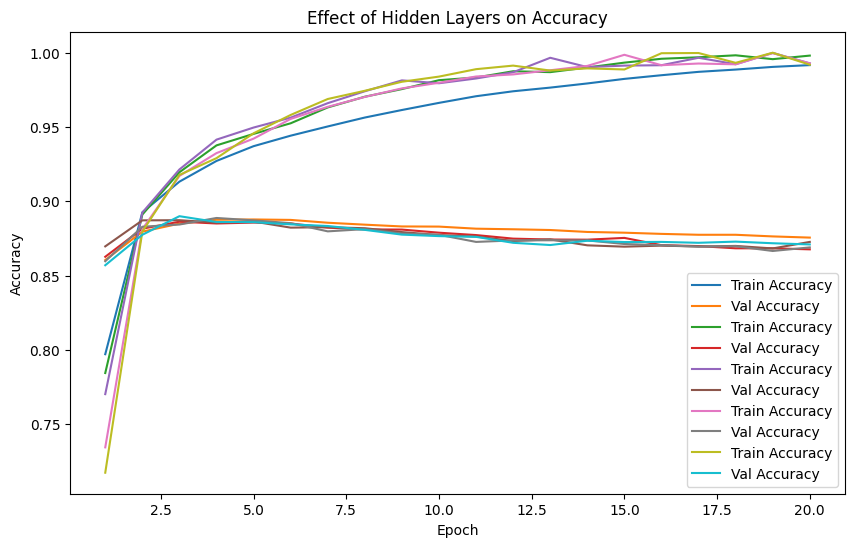

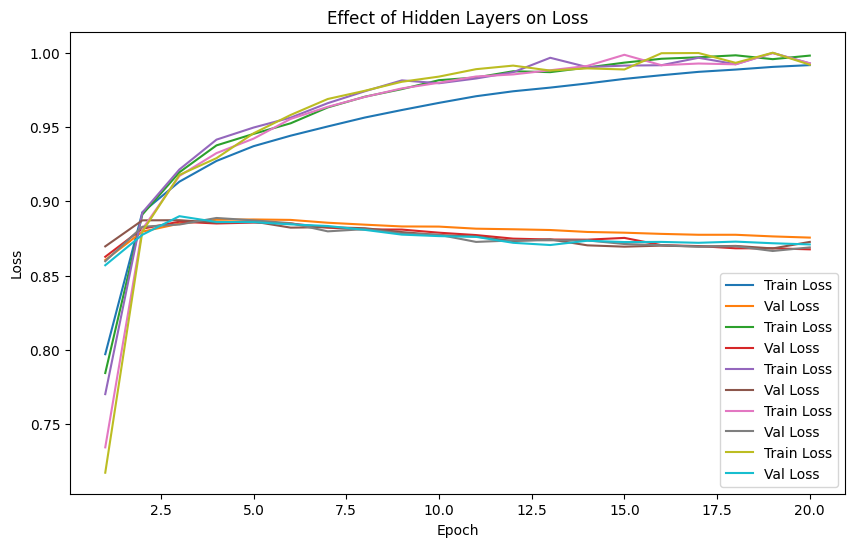

In [7]:
# Experiment 1: Evaluating models with varying hidden layer counts
print("\n=== Experiment 1: Hidden Layer Variation ===")

layer_variations = [1, 2, 3, 4, 5]
layer_histories = {}

for layers_count in layer_variations:
    print(f"Training neural net with {layers_count} hidden layer(s)...")

    nn_model = build_nn_model(n_layers=layers_count, n_units=16)
    training_log = nn_model.fit(
        x_train_partial, y_train_partial,
        epochs=20,
        batch_size=512,
        validation_data=(x_val, y_val),
        verbose=1
    )

    layer_histories[layers_count] = training_log

    val_accuracy = training_log.history['val_accuracy'][-1]
    test_accuracy = nn_model.evaluate(x_test, y_test, verbose=0)[1]

    experiment_logs['Hidden Layers'][layers_count] = {
        'Validation Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy
    }

# Plotting accuracy and loss for different hidden layer configurations
plot_training_curves(layer_histories, 'Effect of Hidden Layers on Accuracy', 'Accuracy')
plot_training_curves(layer_histories, 'Effect of Hidden Layers on Loss', 'Loss')



=== Experiment 2: Neuron Count Variation ===
Training model using 32 neurons in each hidden layer...
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.7030 - auc: 0.7676 - loss: 0.5940 - precision: 0.6935 - recall: 0.7451 - val_accuracy: 0.8601 - val_auc: 0.9378 - val_loss: 0.3779 - val_precision: 0.8253 - val_recall: 0.9173
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8883 - auc: 0.9511 - loss: 0.3281 - precision: 0.8796 - recall: 0.8985 - val_accuracy: 0.8784 - val_auc: 0.9500 - val_loss: 0.3077 - val_precision: 0.9040 - val_recall: 0.8496
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9176 - auc: 0.9727 - loss: 0.2376 - precision: 0.9158 - recall: 0.9188 - val_accuracy: 0.8875 - val_auc: 0.9535 - val_loss: 0.2795 - val_precision: 0.8868 - val_recall: 0.8912
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9308 - auc: 0.9808 - loss: 0.1921 - precision: 0.9289 - recall: 0.9323 - val_accuracy: 0.8851 - val_auc: 0.953

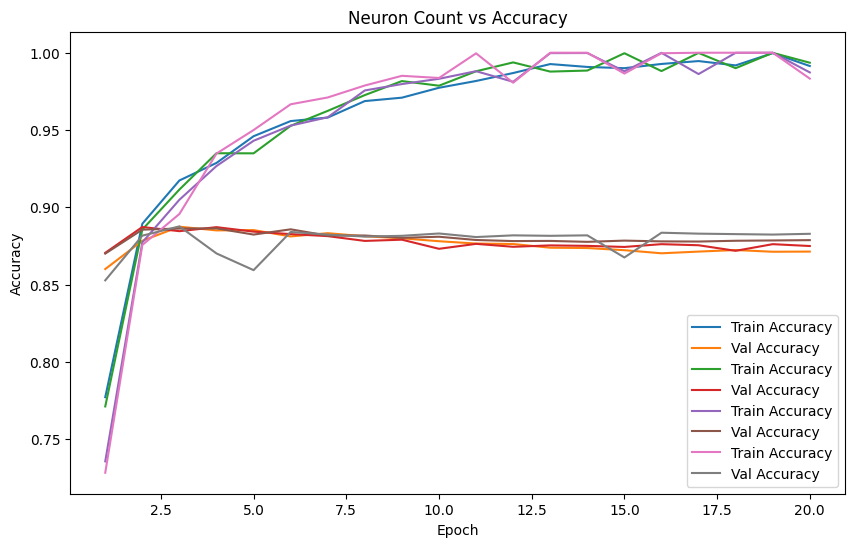

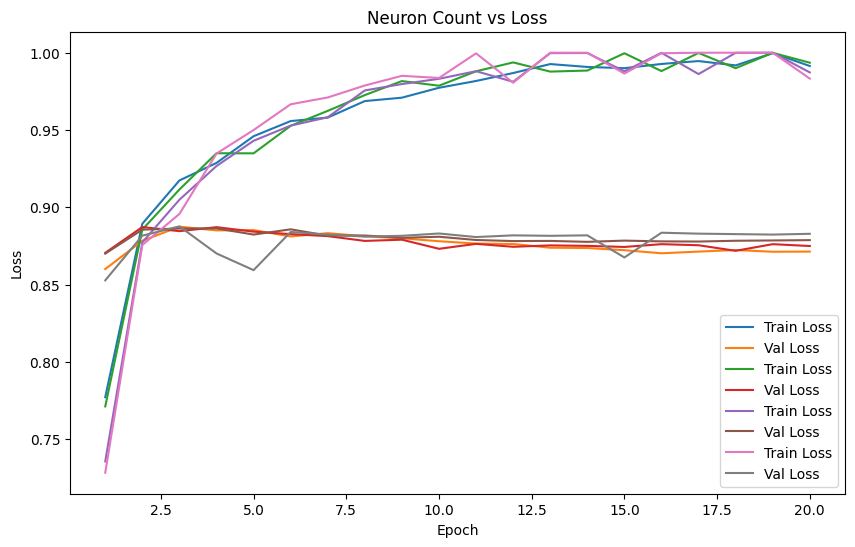

In [8]:
# Experiment 2: Assessing the impact of neuron count per hidden layer
print("\n=== Experiment 2: Neuron Count Variation ===")

neuron_configurations = [32, 64, 128, 256]
neuron_histories = {}

for unit_count in neuron_configurations:
    print(f"Training model using {unit_count} neurons in each hidden layer...")

    neuron_model = build_nn_model(n_layers=2, n_units=unit_count)
    neuron_history = neuron_model.fit(
        x_train_partial, y_train_partial,
        epochs=20,
        batch_size=512,
        validation_data=(x_val, y_val),
        verbose=1
    )

    neuron_histories[unit_count] = neuron_history

    validation_accuracy = neuron_history.history['val_accuracy'][-1]
    test_accuracy = neuron_model.evaluate(x_test, y_test, verbose=0)[1]

    experiment_logs['Neuron Count'][unit_count] = {
        'Validation Accuracy': validation_accuracy,
        'Test Accuracy': test_accuracy
    }

# Visualizing how neuron count influences model performance
plot_training_curves(neuron_histories, 'Neuron Count vs Accuracy', 'Accuracy')
plot_training_curves(neuron_histories, 'Neuron Count vs Loss', 'Loss')



=== Experiment 3: Loss Function Evaluation ===
Training model using Mean Squared Error (MSE) as the loss function...
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6700 - auc: 0.7590 - loss: 0.2204 - precision: 0.7406 - recall: 0.5071 - val_accuracy: 0.8519 - val_auc: 0.9288 - val_loss: 0.1416 - val_precision: 0.8802 - val_recall: 0.8183
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8801 - auc: 0.9431 - loss: 0.1232 - precision: 0.8841 - recall: 0.8734 - val_accuracy: 0.8740 - val_auc: 0.9461 - val_loss: 0.1072 - val_precision: 0.8978 - val_recall: 0.8470
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9110 - auc: 0.9647 - loss: 0.0872 - precision: 0.9104 - recall: 0.9108 - val_accuracy: 0.8807 - val_auc: 0.9497 - val_loss: 0.0940 - val_precision: 0.8527 - val_recall: 0.9234
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9196 - auc: 0.9714 - loss: 0.0717 - precision: 0.9178 - recall: 0.9208 - val_accuracy: 0.8786

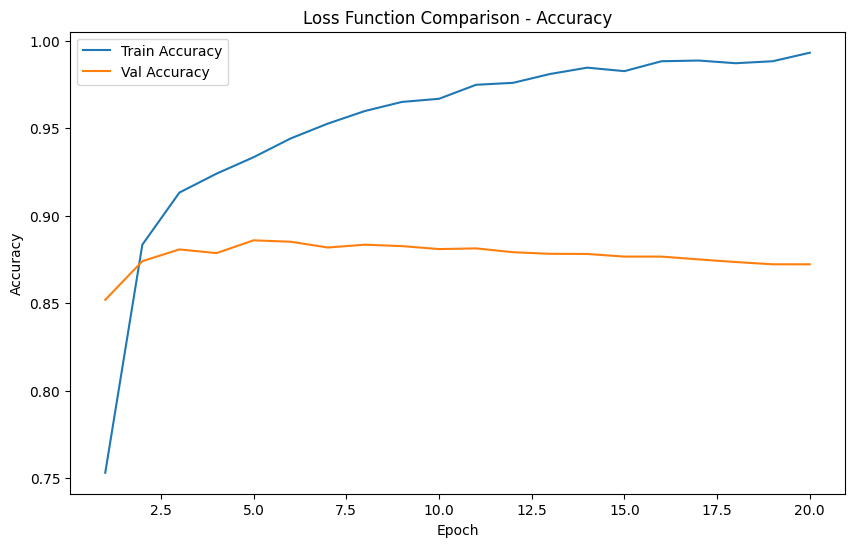

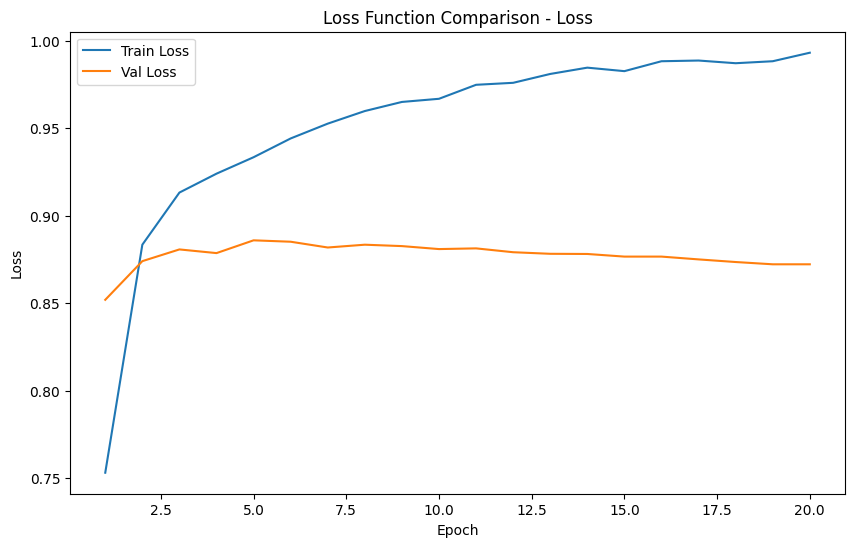

In [9]:
# Experiment 3: Evaluating performance with different loss functions
print("\n=== Experiment 3: Loss Function Evaluation ===")

loss_function_histories = {}

print("Training model using Mean Squared Error (MSE) as the loss function...")
mse_net = build_nn_model(loss_type='mse')
mse_log = mse_net.fit(
    x_train_partial, y_train_partial,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=1
)

loss_function_histories['MSE'] = mse_log

validation_acc = mse_log.history['val_accuracy'][-1]
test_acc = mse_net.evaluate(x_test, y_test, verbose=0)[1]

experiment_logs['Loss Function'] = {
    'MSE': {
        'Validation Accuracy': validation_acc,
        'Test Accuracy': test_acc
    }
}

# Visualizing MSE loss performance
plot_training_curves(loss_function_histories, 'Loss Function Comparison - Accuracy', 'Accuracy')
plot_training_curves(loss_function_histories, 'Loss Function Comparison - Loss', 'Loss')



=== Experiment 4: Activation Function Comparison ===
Training model using 'tanh' activation function...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.6943 - auc: 0.7686 - loss: 0.5713 - precision: 0.6955 - recall: 0.6815 - val_accuracy: 0.8701 - val_auc: 0.9423 - val_loss: 0.3541 - val_precision: 0.8729 - val_recall: 0.8696
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9031 - auc: 0.9634 - loss: 0.2920 - precision: 0.8997 - recall: 0.9060 - val_accuracy: 0.8869 - val_auc: 0.9533 - val_loss: 0.2852 - val_precision: 0.8868 - val_recall: 0.8898
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9312 - auc: 0.9786 - loss: 0.2061 - precision: 0.9294 - recall: 0.9325 - val_accuracy: 0.8873 - val_auc: 0.9548 - val_loss: 0.2744 - val_precision: 0.9027 - val_recall: 0.8708
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9472 - auc: 0.9865 - loss: 0.1573 - precision: 0.9491 - recall: 0.9444 - val_accuracy: 0.8872 - val_auc: 0.9538 - val_loss: 0.2794 - val_precision: 0.8775 - val_recall: 0.9028
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━

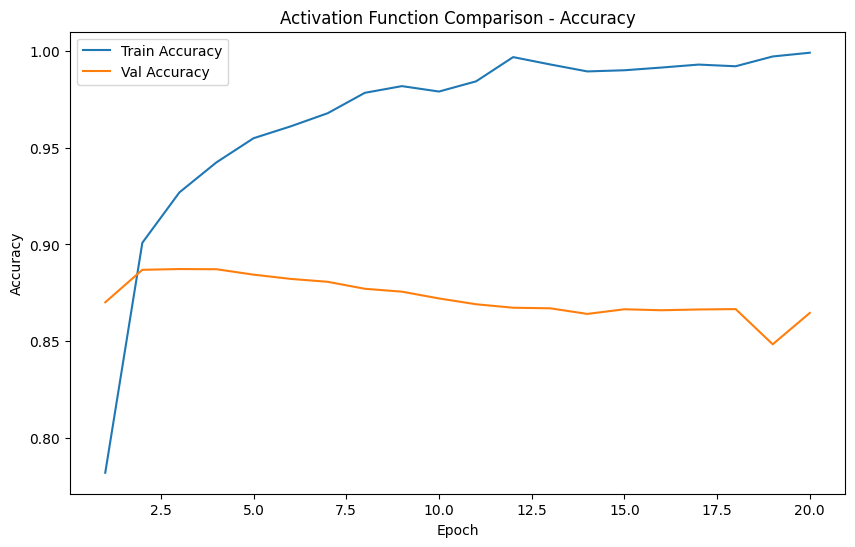

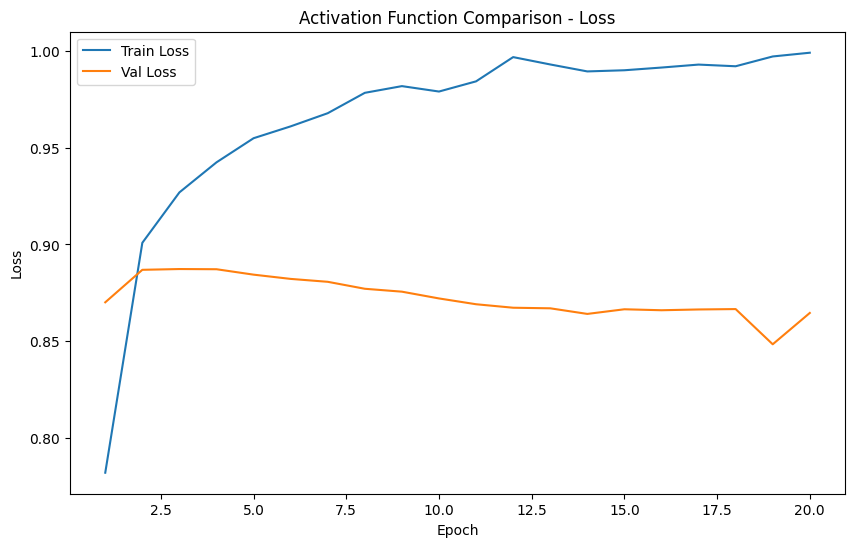

In [15]:
# Experiment 4: Comparing different activation functions
print("\n=== Experiment 4: Activation Function Comparison ===")

activation_histories = {}

print("Training model using 'tanh' activation function...")
tanh_net = build_nn_model(act_func='tanh')
tanh_log = tanh_net.fit(
    x_train_partial, y_train_partial,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=1
)

activation_histories['tanh'] = tanh_log

val_accuracy = tanh_log.history['val_accuracy'][-1]
test_accuracy = tanh_net.evaluate(x_test, y_test, verbose=0)[1]

experiment_logs['Activation Function']['tanh'] = {
    'Validation Accuracy': val_accuracy,
    'Test Accuracy': test_accuracy
}

# Display training and validation curves
plot_training_curves(activation_histories, 'Activation Function Comparison - Accuracy', 'Accuracy')
plot_training_curves(activation_histories, 'Activation Function Comparison - Loss', 'Loss')


Loading IMDB dataset: 

--- Experiment 5: Dropout Regularization ---
Training model with dropout rate 0.3...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.6313 - auc: 0.6824 - loss: 0.6520 - precision: 0.6403 - recall: 0.5667 - val_accuracy: 0.8364 - val_auc: 0.9251 - val_loss: 0.4868 - val_precision: 0.9059 - val_recall: 0.7546
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8348 - auc: 0.9091 - loss: 0.4582 - precision: 0.8531 - recall: 0.8067 - val_accuracy: 0.8742 - val_auc: 0.9449 - val_loss: 0.3733 - val_precision: 0.9045 - val_recall: 0.8397
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8823 - auc: 0.9478 - loss: 0.3472 - precision: 0.8882 - recall: 0.8732 - val_accuracy: 0.8833 - val_auc: 0.9512 - val_loss: 0.3146 - val_precision: 0.9028 - val_recall: 0.8619
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9078 - auc: 0.9621 - loss: 0.2816 - precision: 0.9090 - recall: 0.9051 - val_accuracy: 0.8816 - val_auc: 0.9529 - val_loss: 0.3027 - val_precision: 0.9217 - val_recall: 0.8367
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━

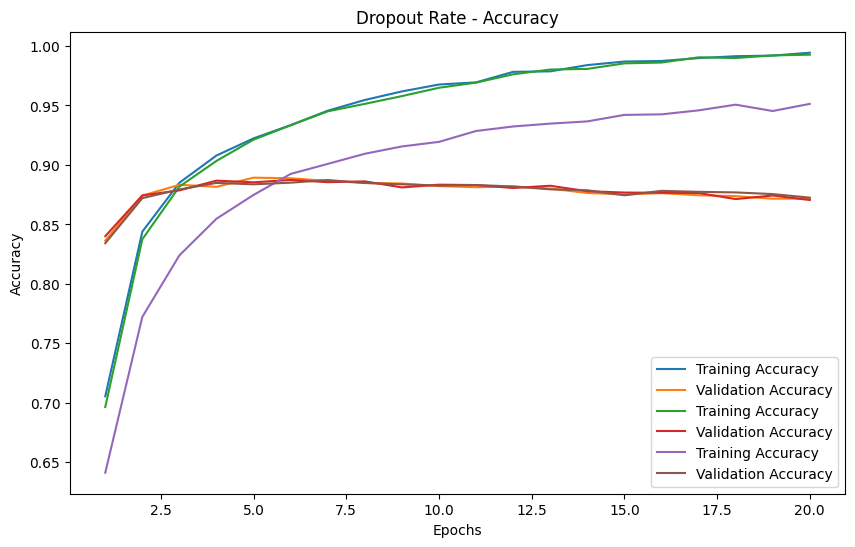

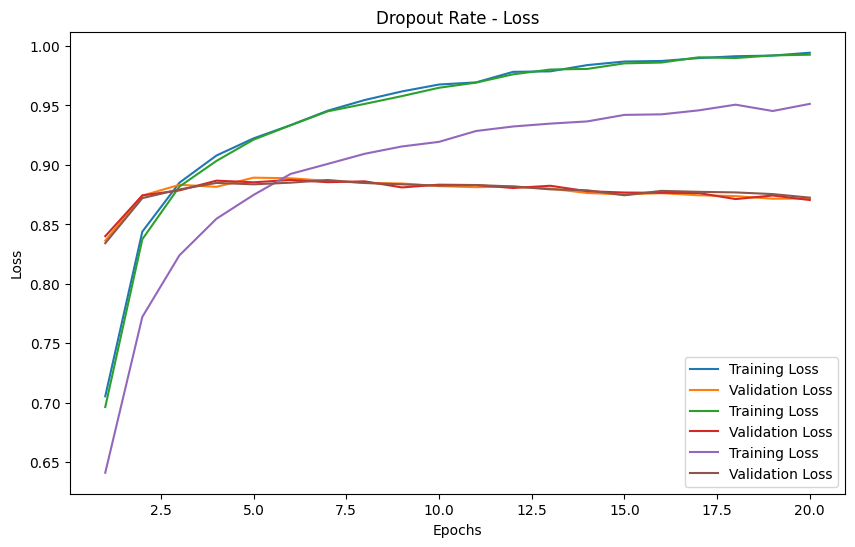

In [29]:
# Load IMDB dataset
print("Loading IMDB dataset: ")
(train_reviews, train_labels), (test_reviews, test_labels) = imdb.load_data(num_words=10000)

# Function to convert sequences into binary multi-hot encoding
def encode_sequences(sequences, vocab_size=10000):
    """
    Converts sequences of word indices into a binary multi-hot encoded matrix.
    """
    output_matrix = np.zeros((len(sequences), vocab_size))
    for idx, seq in enumerate(sequences):
        output_matrix[idx, seq] = 1.0
    return output_matrix

# Transform training and testing data into vectorized format
x_train = encode_sequences(train_reviews)
x_test = encode_sequences(test_reviews)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

# Split the data into training and validation sets
x_validation = x_train[:10000]
x_partial_train = x_train[10000:]
y_validation = y_train[:10000]
y_partial_train = y_train[10000:]

# Function to construct the neural network model
def construct_model(hidden_layers=2, neurons=16, activation_fn='relu', dropout=0.0, loss_fn='binary_crossentropy'):
    """
    Builds and compiles a sequential neural network model.
    """
    model = keras.Sequential()
    model.add(layers.Dense(neurons, activation=activation_fn, input_shape=(10000,)))

    for _ in range(hidden_layers - 1):
        model.add(layers.Dense(neurons, activation=activation_fn))
        if dropout > 0.0:
            model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss=loss_fn,
                  metrics=['accuracy', 'precision', 'recall', 'auc'])
    return model

# Dictionary to store experiment results
experiment_results = {
    'Hidden Layers': {},
    'Neuron Count': {},
    'Loss Function': {},
    'Activation Function': {},
    'Dropout Rate': {}
}

# Function to visualize training and validation metrics
def visualize_metrics(history_dict, title, y_label):
    """
    Plots accuracy or loss over epochs for different experimental setups.
    """
    plt.figure(figsize=(10, 6))
    for label, history in history_dict.items():
        epochs = range(1, len(history.history['accuracy']) + 1)
        plt.plot(epochs, history.history['accuracy'], label=f'Training {y_label}')
        plt.plot(epochs, history.history['val_accuracy'], label=f'Validation {y_label}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


# Experiment 5: Dropout regularization
print("\n--- Experiment 5: Dropout Regularization ---")
dropout_rates = [0.3, 0.5, 0.7]
histories_dropout = {}
for rate in dropout_rates:
    print(f"Training model with dropout rate {rate}...")
    model = construct_model(dropout=rate)
    history = model.fit(x_partial_train, y_partial_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_validation, y_validation),
                        verbose=1)
    histories_dropout[rate] = history
    val_acc = history.history['val_accuracy'][-1]
    test_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    experiment_results['Dropout Rate'][rate] = {'Validation Accuracy': val_acc, 'Test Accuracy': test_acc}
visualize_metrics(histories_dropout, 'Dropout Rate - Accuracy', 'Accuracy')
visualize_metrics(histories_dropout, 'Dropout Rate - Loss', 'Loss')